# ARCH和GARCH模型的广义矩法
By Andrw J


当一个时间序列的波动性也是自回归的时，自回归条件异方差(ARCH)就出现了。

In [1]:
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt

## 模拟一个GARCH(1,1)案例
我们将首先使用蒙特卡罗抽样来模拟GARCH(1,1)过程。我们的模型是

$$\sigma_1 = \sqrt{\frac{a_0}{1-a_1-b_1}} \\
\sigma_t^2 = a_0 + a_1 x_{t-1}^2+b_1 \sigma_{t-1}^2 \\
x_t = \sigma_t \epsilon_t \\
\epsilon \sim \mathcal{N}(0, 1)$$

我们的参数是$a_0 = 1$， $a_1=0.1$， $b_1=0.8$。我们将降低模拟值的前10%(衰退)。

In [2]:
# Define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [3]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    return X, sigma

现在我们将把GARCH(1,1)过程的尾部与正态分布值进行比较。我们希望看到更肥的尾部，因为GARCH(1,1)过程将更频繁地经历极值。

In [4]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in
X = X / np.std(X) # Normalize X

def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[1.52222222e-01, 2.32222222e-02, 2.77777778e-03, 5.55555556e-04],
       [1.58655254e-01, 2.27501319e-02, 1.34989803e-03, 3.16712418e-05]])

果然，GARCH(1,1)过程的尾部更肥一些。我们也可以从图上看，虽然看起来有点不明显。

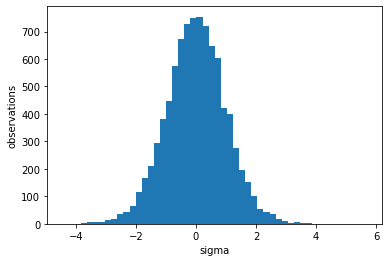

In [5]:
plt.hist(X, bins=50)
plt.xlabel('sigma')
plt.ylabel('observations');

In [6]:
# Sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X, X2])

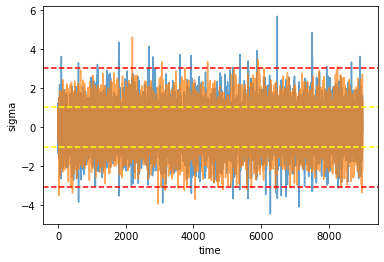

In [7]:
# Plot both the GARCH and normal values
plt.plot(both.T, alpha=.7);
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma');

我们在这里看到的是蓝色的GARCH过程和橙色的正态过程。图上分别画出了1std和3std线。我们可以看到，蓝色的GARCH过程比橙色的正态过程更容易跨越3std线。

## ARCH行为测试
第一步是测试ARCH状况。为此，我们在$x_t$上运行回归，以拟合以下模型。

$$x_t^2 = a_1 x_{t-1}^2 + \dots + a_p x_{t-p}^2$$

我们使用OLS来估计$\hat\theta = (\hat a_0, \hat a_1, \dots, \hat a_p)$和协方差矩阵$\hat\Omega$。然后我们可以计算测试统计量

$$F = \hat\theta \hat\Omega^{-1} \hat\theta'$$

如果$F$大于$\mathcal(X)^2(p)$分布中的95%置信条，我们将拒绝。

为了进行测试，我们将$p设置为20$，然后看看会得到什么。

(20, 1)
F =  420.53419327515326
p-value =  0.0
[[ 9.82142789e+01  4.04136133e+01  6.17571551e+01  5.01936011e+01
   6.23333340e+01  6.82008598e+01  1.02908178e+01  1.99598635e-02
   6.71800948e+01  2.43013905e+01  3.71938601e+01  1.60271772e+01
   9.23310844e+01 -3.88825644e+00  2.23099007e+01  2.66224975e+01
  -6.49015435e+00  3.84277066e+01  1.23854568e-01  2.79559500e+01]]


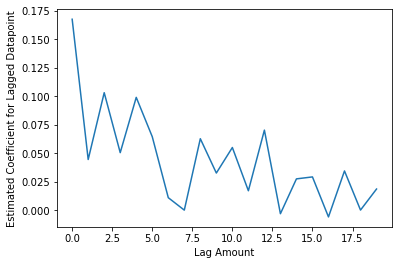

In [8]:
X, _ = simulate_GARCH(1100, a0, a1, b1, sigma1)
X = X[100:] # Drop burn in

p = 20

# Drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
X2 = np.ndarray((980, p))
for i in range(p, 1000):
    X2[i-p, :] = np.asarray((X**2)[i-p:i])[::-1]

model = sm.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = (theta * np.linalg.inv(omega) * theta.T).item()

print( np.asarray(theta.T).shape)

plt.plot(theta.T)
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

print ('F = ' ,F)

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print ('p-value = ',pvalue)

# Finally let's look at the significance of each a_p as measured by the standard deviations away from 0
print (theta/np.diag(omega))

## 用MLE拟合GARCH(1,1)
一旦我们确定数据可能有一个底层的GARCH(1,1)模型，我们就可以通过估计参数来将GARCH(1,1)适合于数据。

为此，我们需要对数似然函数

$$\mathcal{L}(\theta) = \sum_{t=1}^T - \ln \sqrt{2\pi} - \frac{x_t^2}{2\sigma_t^2} - \frac{1}{2}\ln(\sigma_t^2)$$

要计算这个函数的值，我们需要$x_t$和$\sigma_t$来计算$1 \leq t \leq T$。我们有$x_t$，但是我们需要计算$\sigma_t$。为此，我们需要猜测$\sigma_1$。我们的猜测是$\sigma_1^2 = \hat E[x_t^2]$。一旦我们有了最初的猜测，我们就用这个方程来计算剩下的$\sigma$

$$\sigma_t^2 = a_0 + a_1 x_{t-1}^2 + b_1\sigma_{t-1}^2$$

In [9]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in

In [10]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

让我们看看我们刚刚生成的sigmas。

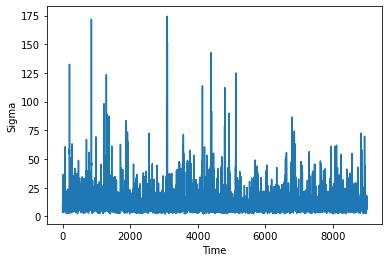

In [11]:
plt.plot( compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma');

现在，我们可以计算$\sigma_t$，我们将定义实际的对数似然函数。这个函数将把我们的观察值$x$和$\theta$作为输入，并返回$-\mathcal{L}(\theta)$。需要注意的是，我们返回的是负对数似然值，因为通过这种方式，我们的数值优化器可以在最大化对数似然值的同时最小化函数。

注意，我们在这个函数中不断地重新计算$\sigma_t$。

In [12]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for t in range(T)]
    )

现在我们进行数值优化来得到我们的估计值
$$\hat\theta = \arg \max_{(a_0, a_1, b_1)}\mathcal{L}(\theta) = \arg \min_{(a_0, a_1, b_1)}-\mathcal{L}(\theta)$$

我们有一些约束条件

$$a_1 \geq 0, b_1 \geq 0, a_1+b_1 < 1$$

In [13]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print ('theta MLE: ' ,theta_mle)

d:\python\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


theta MLE:  [0.8600533  0.10409364 0.81297695]


现在我们想要一个方法来检查我们的估计。我们来看两件事:

1. 残差的尾部有多肥。
2. 在Jarque-Bera正态性检验下的残差有多正常。

我们将在`check_theta_estimate`函数中执行这两个操作。

In [14]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print ('Tails table')
    print (compare_tails_to_normal(epsilon / np.std(epsilon)))
    print ('')
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print( 'Jarque-Bera probability normal: ' ,pvalue)
    
check_theta_estimate(X, theta_mle)

Tails table
[[1.58555556e-01 2.25555556e-02 1.11111111e-03 0.00000000e+00]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]

Jarque-Bera probability normal:  0.5115007906268965


## 用于估计GARCH(1,1)参数的GMM
我们刚刚使用MLE计算了一个估计值，但是我们也可以使用广义矩法(GMM)来估计GARCH(1,1)参数。

为了做到这一点，我们需要定义我们的矩。我们将使用4。

1. 残差 $\hat\epsilon_t = x_t / \hat\sigma_t$
2. 残差的方差 $\hat\epsilon_t^2$
3. 偏度 $\mu_3/\hat\sigma_t^3 = (\hat\epsilon_t - E[\hat\epsilon_t])^3 / \hat\sigma_t^3$
4. 峰度 $\mu_4/\hat\sigma_t^4 = (\hat\epsilon_t - E[\hat\epsilon_t])^4 / \hat\sigma_t^4$

In [15]:
# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

GMM现在有三个步骤。

以$W$作为单位矩阵。

1. 通过使用数值优化来最小化$\hat\theta_1$

$$\min_{\theta \in \Theta} \left(\frac{1}{T} \sum_{t=1}^T g(x_t, \hat\theta)\right)' W \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta)\right)$$

2. 根据估计的$\theta$的协方差重新计算$W$。(更多关注具有解释力的参数)

$$\hat W_{i+1} = \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta_i)g(x_t, \hat\theta_i)'\right)^{-1}$$

3.重复，直到$|\hat\theta_{i+1} - \hat\theta_i| < \epsilon$，或达到迭代阈值。

初始化$W$和$T$并定义我们需要最小化的目标函数。

In [16]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.asmatrix([m1, m2, m3, m4]).T
    
    return (G.T * W * G).item()

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.asmatrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

现在我们准备执行迭代最小化步骤。

In [17]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print ('Iteration ' ,i, ' theta: ' ,theta_gmm_estimate)
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))

check_theta_estimate(X, theta_gmm_estimate)

Iteration  0  theta:  [0.86003276 0.10417765 0.81301408]
Iteration  1  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  2  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  3  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  4  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  5  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  6  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  7  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  8  theta:  [0.86006673 0.10438456 0.81325927]
Iteration  9  theta:  [0.86006673 0.10438456 0.81325927]
Tails table
[[1.58666667e-01 2.25555556e-02 1.11111111e-03 0.00000000e+00]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]

Jarque-Bera probability normal:  0.5124684452287288


## 预测未来:如何实际运用我们所做的
现在我们已经为我们的观察建立了一个模型，我们希望能够预测未来的波动会是什么样子。为此，我们可以使用原始的GARCH动态和估计的参数模拟更多的值。

我们要做的第一件事是计算初始的$\sigma_t$。计算sigma平方，然后取最后一个。

In [18]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

3.111952599776885

现在我们只需要向前采样值。

In [19]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

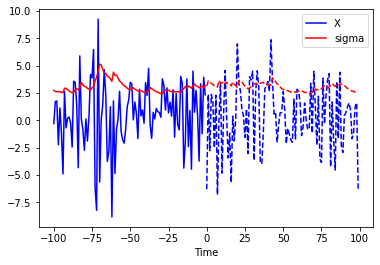

In [20]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma']);

我们应该注意到，因为我们是用随机游走向前移动的，这个分析应该给我们一个sigma的大小的感觉，因此我们可能面临的风险。它不应该精确地建模x的未来值。在实践中，您可能希望使用蒙特卡罗抽样来生成数千个未来场景，然后查看潜在的输出范围。我们现在就试试。请记住，这是一种非常简单的分析方法，还有更好的技术，如贝叶斯锥。

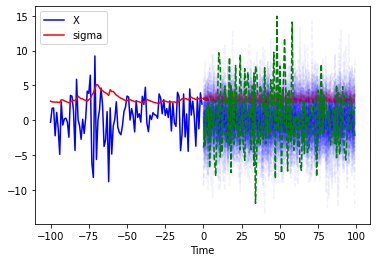

In [21]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])

max_X = [-np.inf]
min_X = [np.inf]
for i in range(100):
    X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
    if max(X_forecast) > max(max_X):
        max_X = X_forecast
    elif min(X_forecast) < min(max_X):
        min_X = X_forecast
    plt.plot(range(0, 100), X_forecast, 'b--', alpha=0.05)
    plt.plot(range(0, 100), sigma_forecast, 'r--', alpha=0.05)

# Draw the most extreme X values specially
plt.plot(range(0, 100), max_X, 'g--', alpha=1.0)
plt.plot(range(0, 100), min_X, 'g--', alpha=1.0);